In [1]:
%matplotlib inline
figsize = (10,3)

# Input Datasets  

In [2]:
import pandas, numpy
pandas.options.display.float_format = '{:,.4f}'.format
data_folder = '../data'
date_format='%Y-%m-%d' #truncate datetimes to dates
id_columns = ["id","company_id","invoice_id","account_id","customer_id"]
id_column_types = dict(zip(id_columns,[str] * len(id_columns)))
invoices = pandas.read_csv(data_folder + '/invoice.csv', na_values='inf', dtype=id_column_types,
                           parse_dates=['invoice_date', 'due_date', 'cleared_date'], date_format=date_format)
payments = pandas.read_csv(data_folder + '/invoice_payments.csv', na_values='inf', dtype=id_column_types,
                           parse_dates=['transaction_date'], date_format=date_format)

## Dataset Definitions & Relationships

We have two input datasets: invoices and their payments.
- Payments are amounts in time, which are directly mapped to companies. 
- Invoices can have multiple payments, but usually only have 1. 

In [3]:
invoices.rename(columns={"id":"invoice_id"}, inplace=True)
invoices.dtypes

invoice_id                          object
due_date                    datetime64[ns]
invoice_date                datetime64[ns]
status                              object
amount_inv                         float64
currency                            object
company_id                          object
customer_id                         object
account_id                          object
cleared_date                datetime64[ns]
root_exchange_rate_value           float64
dtype: object

In [4]:
payments.dtypes

amount                             float64
root_exchange_rate_value           float64
transaction_date            datetime64[ns]
invoice_id                          object
company_id                          object
converted_amount                   float64
dtype: object

In [5]:
#The join key will be invoice_id, so it must be unique (and it is).
invoices.invoice_id.value_counts(dropna=False).value_counts(dropna=False)\
.to_frame(name="ids").rename_axis('invoices_per_id')

,ids
invoices_per_id,
1,113085


In [6]:
#all payments are represented in both datasets 
len(set(payments.invoice_id) - set(invoices.invoice_id))

0

In [7]:
#7% of invoices do not have payments yet
len(set(invoices.invoice_id) - set(payments.invoice_id))/invoices.__len__()

0.07127382057744175

In [8]:
#invoices usually have one payment but may have more
payments.invoice_id.value_counts(dropna=False).value_counts(dropna=False, normalize=True)\
.to_frame(name="invoices").rename_axis('payments_per_invoice')

,invoices
payments_per_invoice,
1,0.9419
2,0.0548
3,0.0026
4,0.0006
5,0.0001
6,0.0001
14,0.0000
9,0.0000
8,0.0000


## Entity Definitions & Relationships

- Company: business entity for which Tesorio is forecasting cash collected. There are only two. Each company collects using multiple currencies from multiple customers. 
- Account: **In this limited dataset, accounts and companies are synonymous, so we ignore accounts.**  
- Customer: metadata about an invoice which is specific to each company. Each customer can have multiple currencies.

In [9]:
invoices.groupby("company_id")[["customer_id","currency"]].nunique()

,customer_id,currency
company_id,,
114,4509,15
14,546,13


In [10]:
invoices.groupby("customer_id").company_id.nunique().value_counts()\
.to_frame(name='customers').rename_axis('companies_per_customer')

,customers
companies_per_customer,
1,5055


In [11]:
invoices.groupby(["customer_id"]).currency.nunique().value_counts()\
.to_frame(name='customers').rename_axis('currencies_per_customer')

,customers
currencies_per_customer,
1,4426
2,583
3,39
4,7


In [12]:
invoices.groupby("company_id").account_id.nunique().to_frame(name="unique_accounts")

,unique_accounts
company_id,
114,1
14,1


In [13]:
invoices.groupby("account_id").company_id.nunique().value_counts()\
.to_frame(name='count').rename_axis('companies_per_account')

,count
companies_per_account,
1,2


## Data Cleaning Needs

### Payments

Transaction data begins in 2011 and ends 2021-05-18. We will assume this is when the data was pulled. 

In [14]:
payments.__len__()

111623

In [15]:
payment_stats = payments.describe(include='all')
payment_stats.loc['% populated'] = payment_stats.loc['count']/payments.__len__()
payment_stats

,amount,root_exchange_rate_value,transaction_date,invoice_id,company_id,converted_amount
count,"111,622.0000","111,623.0000",111623,111623,111623,"111,622.0000"
unique,NaN,NaN,NaN,105025,2,NaN
top,NaN,NaN,NaN,48171,114,NaN
freq,NaN,NaN,NaN,14,108124,NaN
mean,"9,416.9806",0.9684,2018-03-04 09:52:41.445221376,NaN,NaN,"9,128.7160"
min,0.0000,0.0008,2011-04-13 00:00:00,NaN,NaN,0.0000
25%,"4,078.6262",1.0000,2016-08-05 00:00:00,NaN,NaN,"3,180.9720"
50%,"9,332.6655",1.0000,2018-08-18 00:00:00,NaN,NaN,"8,819.6202"
75%,"14,651.4959",1.0000,2020-02-15 00:00:00,NaN,NaN,"14,612.8617"
max,"19,999.8792",3.2533,2021-05-18 00:00:00,NaN,NaN,"61,209.4348"


In [16]:
last_transaction_date = payments.transaction_date.max()
first_transaction_date = payments.transaction_date.min()
first_transaction_date, last_transaction_date

(Timestamp('2011-04-13 00:00:00'), Timestamp('2021-05-18 00:00:00'))

In [17]:
#converted_amount is reliable
(((payments.amount * payments.root_exchange_rate_value) - payments.converted_amount).abs()).max()

1.0913936421275139e-11

In [18]:
payments[payments.amount.isnull()!=payments.converted_amount.isnull()].__len__()

0

array([[<Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'root_exchange_rate_value'}>,
        <Axes: title={'center': 'converted_amount'}>]], dtype=object)

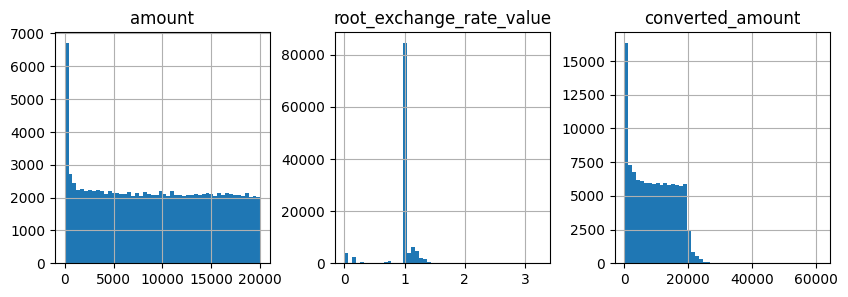

In [19]:
payments.select_dtypes(include='float').hist(bins=50, figsize=figsize, layout=(1,3))

### Invoices

Must become active within the date range of the transactions data to ensure completeness.

In [20]:
#opened outside of payment data time period or after they were due - need to filter 
(invoices.loc[invoices.invoice_date>last_transaction_date].__len__(), 
invoices.loc[invoices.invoice_date<first_transaction_date].__len__(), 
invoices.loc[invoices.invoice_date.dt.to_period('M')>invoices.due_date.dt.to_period('M')].__len__())

(79, 79, 14)

In [21]:
invoices = invoices.loc[(invoices.invoice_date>=first_transaction_date) &
                        (invoices.invoice_date<=last_transaction_date) & 
                        (invoices.invoice_date.dt.to_period('M')<=invoices.due_date.dt.to_period('M'))]

In [22]:
#to compare to payments. Are we holding the customer accountable to USD or their own currency?
invoices['converted_amount_inv'] = invoices.amount_inv * invoices.root_exchange_rate_value

In [23]:
invoices_stats = invoices.describe(include='all')
invoices_stats.loc['% populated'] = invoices_stats.loc['count']/invoices.__len__()
invoices_stats

,invoice_id,due_date,invoice_date,status,amount_inv,currency,company_id,customer_id,account_id,cleared_date,root_exchange_rate_value,converted_amount_inv
count,112888,112888,112888,112888,"112,888.0000",112888,112888,112888,112888,112888,"112,888.0000","112,888.0000"
unique,112888,NaN,NaN,2,NaN,18,2,5054,2,NaN,NaN,NaN
top,0,NaN,NaN,CLEARED,NaN,USD,114,5,0,NaN,NaN,NaN
freq,1,NaN,NaN,109264,NaN,84998,109695,1786,109695,NaN,NaN,NaN
mean,NaN,2018-03-30 15:44:57.895259136,2018-02-22 18:34:17.288640,NaN,"10,026.6987",NaN,NaN,NaN,NaN,2018-04-27 06:29:11.144497408,0.9708,"9,742.3893"
min,NaN,2011-04-13 00:00:00,2011-04-13 00:00:00,NaN,0.0276,NaN,NaN,NaN,NaN,2011-05-15 00:00:00,0.0008,0.0080
25%,NaN,2016-08-27 00:00:00,2016-07-22 00:00:00,NaN,"5,030.1056",NaN,NaN,NaN,NaN,2016-09-16 00:00:00,1.0000,"4,161.6325"
50%,NaN,2018-09-22 00:00:00,2018-08-19 00:00:00,NaN,"10,018.0136",NaN,NaN,NaN,NaN,2018-10-13 00:00:00,1.0000,"9,588.6353"
75%,NaN,2020-03-21 00:00:00,2020-02-16 00:00:00,NaN,"15,030.4018",NaN,NaN,NaN,NaN,2020-04-21 00:00:00,1.0000,"15,058.0828"
max,NaN,2021-08-29 00:00:00,2021-05-18 00:00:00,NaN,"19,999.9749",NaN,NaN,NaN,NaN,2022-01-01 00:00:00,1.6816,"32,285.4757"


In [24]:
invoices['due_month'] = invoices.due_date.dt.to_period('M')
invoices['months_allowed'] = invoices.due_month - invoices.invoice_date.dt.to_period('M')
invoices.months_allowed = invoices.months_allowed.map(lambda m: m.n if not pandas.isnull(m) else None)
#almost all invoices are due immediately or within 3 months. filter out the rest
invoices.months_allowed.value_counts(normalize=True, dropna=False)

months_allowed
1    0.7645
2    0.1808
0    0.0320
3    0.0199
5    0.0009
4    0.0008
6    0.0003
7    0.0002
11   0.0001
8    0.0001
9    0.0001
12   0.0001
10   0.0001
13   0.0000
18   0.0000
14   0.0000
16   0.0000
19   0.0000
15   0.0000
Name: proportion, dtype: float64

In [25]:
invoices['months_billing'] = invoices.cleared_date.dt.to_period('M') - invoices.invoice_date.dt.to_period('M')
invoices.months_billing = invoices.months_billing.map(lambda m: m.n if not pandas.isnull(m) else None)
#almost all invoices are cleared within a year. filter out ones that cleared before they opened. will clip to 12.  
invoices.months_billing.value_counts(normalize=True, dropna=False)

months_billing
 1    0.4507
 2    0.2654
 3    0.0810
 0    0.0718
 4    0.0324
 9    0.0213
 5    0.0186
 6    0.0116
 10   0.0086
 7    0.0083
 8    0.0081
 12   0.0067
 11   0.0045
-1    0.0016
 13   0.0015
 14   0.0012
 15   0.0009
 16   0.0006
-2    0.0006
 17   0.0005
-4    0.0004
 18   0.0004
-3    0.0004
 19   0.0003
 20   0.0002
 21   0.0002
-5    0.0002
 24   0.0001
 22   0.0001
 25   0.0001
 23   0.0001
 26   0.0001
 28   0.0001
-7    0.0001
-11   0.0001
-10   0.0001
-9    0.0001
 31   0.0001
 27   0.0001
-6    0.0001
-8    0.0001
 30   0.0001
 29   0.0001
 32   0.0001
-13   0.0000
-15   0.0000
-16   0.0000
-14   0.0000
-12   0.0000
-22   0.0000
-17   0.0000
 34   0.0000
-18   0.0000
 40   0.0000
 38   0.0000
-21   0.0000
-32   0.0000
-19   0.0000
 36   0.0000
 35   0.0000
Name: proportion, dtype: float64

### Exchange Rate

Exchange rates vary for both payments and open invoices. Customers would expect to pay the amount they were originally invoiced in their own currency, not the USD amount originally invoiced. Therefore, we should use raw amounts to determine how much is paid vs due. 

<Axes: title={'center': 'Exchange Rate Spread Ratio'}, xlabel='currency'>

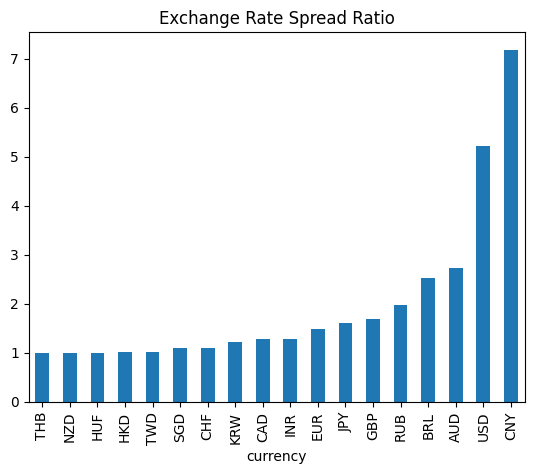

In [26]:
# USD is not is always 1 - it varies a lot
currency_ranges = invoices.groupby("currency").root_exchange_rate_value.describe(percentiles=[])
(currency_ranges['max']/currency_ranges['min']).sort_values().plot(kind='bar', title="Exchange Rate Spread Ratio")

In [27]:
# 1.6% of USD invoices have an exchange rate unequal to 1
invoices_usd = invoices.query("currency=='USD'").copy()
invoices_usd['exchange_rate_is_1'] = invoices_usd['root_exchange_rate_value'] == 1
1 - invoices_usd.exchange_rate_is_1.mean()

0.01562389703287137

In [28]:
# USD exchange rate variations from 1 tend to be invoices which took longer to clear
# This suggests that the invoice exchange rate is "current state data." 
time_to_clear = invoices_usd.cleared_date - invoices_usd.invoice_date
invoices_usd['months_to_clear'] = time_to_clear.map(lambda t: round(t.days/30))

In [29]:
invoices_usd.groupby("exchange_rate_is_1").months_to_clear.agg(['mean','count'])

,mean,count
exchange_rate_is_1,,
False,2.9209,1328
True,1.8937,83670


<Axes: title={'center': '% of USD Invoices With Exchange Rate Equal to 1'}, xlabel='months_to_clear'>

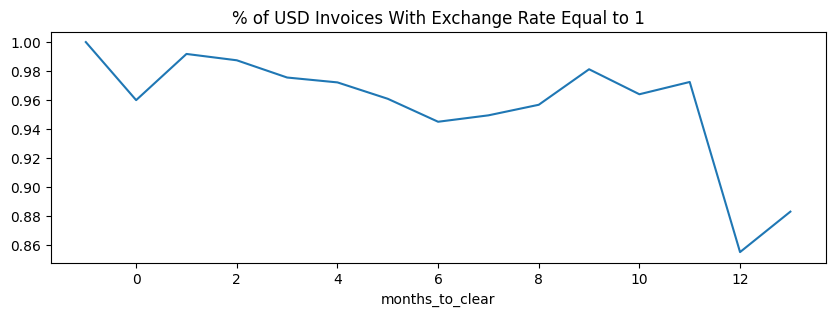

In [30]:
invoices_usd.groupby(invoices_usd.months_to_clear.clip(upper=13, lower=-1))\
.exchange_rate_is_1.mean().plot(title='% of USD Invoices With Exchange Rate Equal to 1', figsize=figsize)

### Invoice status vs cleared date

All invoices have a date cleared. 
When an invoice is open, the date cleared is set to the future, and seems to be an assumed value. 

In [31]:
invoices.loc[invoices.cleared_date.isnull()].__len__()

0

In [32]:
invoices.status.value_counts(normalize=True, dropna=False).to_frame(name="% of Invoices")

,% of Invoices
status,
CLEARED,0.9679
OPEN,0.0321


In [33]:
invoices.loc[invoices.cleared_date.isnull() != (invoices.status == 'OPEN'),['status','cleared_date']]\
.value_counts(dropna=False)

status  cleared_date
OPEN    2022-01-01      3624
Name: count, dtype: int64

In [34]:
#all open invoices have the same cleared date, which is in the future relative to the latest transaction
invoices.loc[invoices.status == 'OPEN'].cleared_date.value_counts(dropna=False)

cleared_date
2022-01-01    3624
Name: count, dtype: int64

In [35]:
#all cleared invoices have a cleared date within the payments data window
invoices.loc[invoices.status == 'CLEARED', ['invoice_date','cleared_date']].agg(['min','max'])

,invoice_date,cleared_date
min,2011-04-13,2011-05-15
max,2021-05-12,2021-05-18


In [36]:
#open invoices are already active
invoices.loc[invoices.status == 'OPEN', ['invoice_date','due_date']].agg(['min','max'])

,invoice_date,due_date
min,2019-06-27,2019-08-31
max,2021-05-18,2021-08-29


### Merging & Checking for Consistency

- No individual payments are more than their invoices. 
- Exchange rates vary across payments.
- Companies are consistent between payments and invoices, when payments are present. 
- Amounts make the most sense in their original currencies vs in USD

In [37]:
payments['transaction_month'] = payments.transaction_date.dt.to_period('M')
invoice_payments = invoices.rename(columns={"amount_inv":"amount","converted_amount_inv":"converted_amount"})\
.merge(payments, on="invoice_id", how='left', suffixes=('_inv', '_pmt'))

In [38]:
invoice_payments.invoice_id.nunique()

112888

In [39]:
duplicated_columns = [col.replace('_pmt','') for col in invoice_payments.columns if col.endswith('_pmt')]
for col in  duplicated_columns:
    inconsistent_rows = invoice_payments.loc[invoice_payments[col + '_pmt']!=invoice_payments[col + '_inv']]
    print(f"{col}: {inconsistent_rows.__len__()/invoice_payments.__len__()} inconsistent rows in merged dataset")

amount: 0.18237593431151808 inconsistent rows in merged dataset
root_exchange_rate_value: 0.3063537368275677 inconsistent rows in merged dataset
company_id: 0.06675985369079206 inconsistent rows in merged dataset
converted_amount: 0.38631322558234915 inconsistent rows in merged dataset


In [40]:
invoice_payments.query("company_id_pmt!=company_id_inv").company_id_pmt.value_counts(dropna=False)

company_id_pmt
NaN    7976
Name: count, dtype: int64

In [41]:
invoice_payments.query("amount_pmt!=amount_inv")[['amount_pmt','amount_inv']].describe()

,amount_pmt,amount_inv
count,"13,812.0000","21,789.0000"
mean,"5,019.0176","9,964.7219"
std,"5,890.4138","5,769.7408"
min,0.0000,2.2108
25%,94.5922,"4,943.9350"
50%,"2,087.8125","9,941.0096"
75%,"9,185.5456","14,932.1411"
max,"19,989.9866","19,999.9749"


In [42]:
#no payment is more than the invoice amount in the original currency
invoice_payments.loc[invoice_payments.amount_pmt>invoice_payments.amount_inv].__len__()

0

In [43]:
#converting to USD creates payments that are higher than invoice totals
invoice_payments.loc[invoice_payments.converted_amount_pmt>invoice_payments.converted_amount_inv].__len__()

11061

### Business Questions for the Data

In [44]:
invoice_payments['amount_pmt_pct'] = (invoice_payments.amount_pmt/invoice_payments.amount_inv)

In [45]:
# Rougly 12% of payments are partial
(invoice_payments.amount_pmt_pct.dropna()<1).mean()

0.12387888354739184

<Axes: title={'center': '% of Invoice Collected with Payment'}, ylabel='Frequency'>

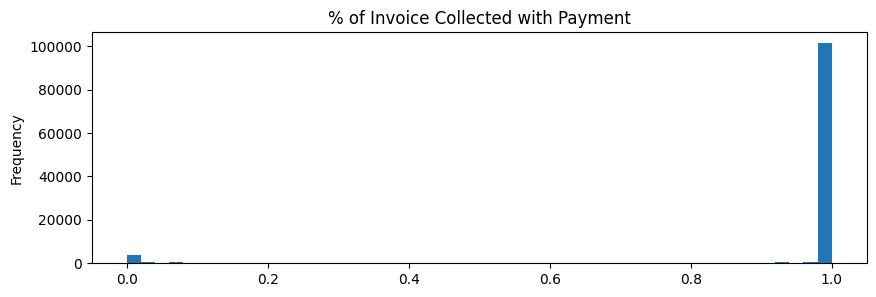

In [46]:
invoice_payments.amount_pmt_pct\
.plot(kind="hist",bins=50, title="% of Invoice Collected with Payment", figsize=figsize)

In [47]:
invoice_payments.sort_values(by=['invoice_id','transaction_date'], inplace=True)

<Axes: title={'center': 'Summed % of Invoice Collected with Payment'}, ylabel='Frequency'>

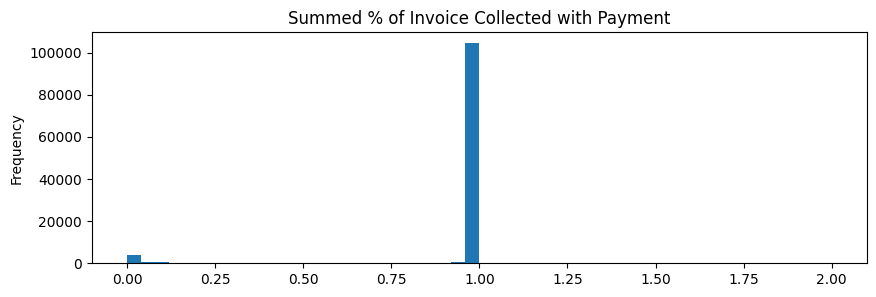

In [48]:
invoice_payments.groupby("invoice_id").amount_pmt_pct.cumsum()\
.plot(kind="hist",bins=50, title="Summed % of Invoice Collected with Payment", figsize=figsize)

In [49]:
#small percent of payments represent overpayments
invoice_payments['pmt_pct_cum'] = invoice_payments.groupby("invoice_id").amount_pmt_pct.cumsum()
(invoice_payments.pmt_pct_cum>1).mean()

0.006654223129912198

In [50]:
#invoices with no transactions: use payments data end date as date of 0 amount 
invoice_payments.transaction_month = invoice_payments.transaction_month\
.fillna(last_transaction_date.to_period('M'))

In [51]:
#there can be multiple transactions per month
invoice_payments.groupby(["invoice_id","transaction_month"]).transaction_date\
.count().value_counts(normalize=True).head()

transaction_date
1   0.8840
0   0.0699
2   0.0446
3   0.0013
4   0.0002
Name: proportion, dtype: float64

In [52]:
#the transactions are not duplicates
invoice_payments.groupby(["invoice_id","transaction_month"]).amount_pmt\
.nunique().value_counts(normalize=True).head()

amount_pmt
1   0.8843
0   0.0700
2   0.0444
3   0.0012
4   0.0001
Name: proportion, dtype: float64

In [53]:
#but they are almost always on the same day
invoice_payments.groupby(["invoice_id","transaction_month"]).transaction_date.nunique()\
.value_counts(normalize=True).head()

transaction_date
1   0.9269
0   0.0699
2   0.0030
3   0.0001
Name: proportion, dtype: float64

In [55]:
payment_totals = invoices.set_index('invoice_id')
payment_totals['pmt_pct_cum'] = invoice_payments.groupby("invoice_id").pmt_pct_cum.max().fillna(0)
payment_totals['transaction_date_max'] = invoice_payments.groupby("invoice_id").transaction_date.max()
payment_totals['collected_date'] = invoice_payments.query("pmt_pct_cum>=1")\
.groupby("invoice_id").transaction_date.min()
payment_totals.reset_index(inplace=True, names=['invoice_id']) 

#### Comparing invoice status and % collected 

- Invoices with cleared status can still have amounts remaining. 
- Invoices with open status are rarely collected. 

In [56]:
# define invoice as collected if payments meet invoice amount in original currencies. 91% are collected
payment_totals['collected'] = payment_totals.collected_date.isnull()==False
payment_totals.collected.mean()

0.9052157891007016

In [57]:
#define cleared based on status. 97% are cleared
payment_totals['cleared'] = payment_totals.status=='CLEARED'
payment_totals.cleared.mean()

0.9678973850187796

In [58]:
#6% of invoices have a mismatch between collected and cleared 
(payment_totals.collected!=payment_totals.cleared).mean()

0.06271702926794699

In [59]:
#on average, 94% of cleared invoices are fully collected, compared to <1% of open ones
#cleared invoices have 96% of their amounts collected on average
payment_totals.groupby("status", as_index=False)[['collected','pmt_pct_cum']].mean()

,status,collected,pmt_pct_cum
0,CLEARED,0.9352,0.9573
1,OPEN,0.0006,0.0063


In [60]:
#67% of invoices that have not been collected are cleared nonetheless 
payment_totals.groupby("collected", as_index=False).cleared.mean()

,collected,cleared
0,False,0.6615
1,True,1.0000


#### Cleared Invoices

Cleared invoices may or may not be collected. If not collected, cleared invoices tend to be more overdue, suggesting that invoices must be cleared at some point.

In [61]:
cleared_invoices = payment_totals.query("cleared == True").copy()
cleared_invoices['months_late'] = \
(cleared_invoices.collected_date.fillna(cleared_invoices.transaction_date_max).dt.to_period('M')\
- cleared_invoices.due_month).map(lambda m: m.n if not pandas.isnull(m) else None)

In [62]:
cleared_invoices.groupby("collected").months_late.agg(['mean','min','max'])

,mean,min,max
collected,,,
False,1.0919,-34.0000,25.0000
True,0.5461,-23.0000,28.0000


#### Comparing date cleared to date collected

Rarely, there can be a delay between the date an invoice is collected to when it is cleared. We will only forecast invoices when they are open AND not collected. 

In [63]:
payment_totals['clear_delay_months'] = (payment_totals.cleared_date.dt.to_period('M') \
- payment_totals.collected_date.dt.to_period('M')).map(lambda m: m.n if not pandas.isnull(m) else None)

In [64]:
payment_totals.__len__()

112888

In [65]:
payment_totals.clear_delay_months.describe(percentiles=[0.001,0.999])

count   102,188.0000
mean          0.1623
std           1.3628
min          -1.0000
0.1%          0.0000
50%           0.0000
99.9%        20.0000
max          39.0000
Name: clear_delay_months, dtype: float64

# Structuring Data for Business Problem

- The model will handle OPEN invoices and classify how many months in the future they will be collected. 
- Define an invoice as open between its invoice date and date cleared or collected, whichever is first. 

## Creating transaction periods to model historical invoices

To model the data, we have to look the invoices in each prior period they were open and calculate when they are collected relative to that time. 

To ensure completeness, the periods we use for modeling must fall within the date range of the transactions data. Since we will forecast a year in advance, the forecast period must also be at a year prior to when the transactions data ends. 

In [66]:
def forecast_periods(invoice_date, last_billing_date):
    period_start = max(invoice_date,first_transaction_date.to_period('M'))
    period_end = min(last_billing_date,(last_transaction_date - pandas.DateOffset(years=1)).to_period('M'))
    return pandas.period_range(period_start, period_end)

payment_totals['last_forecast_date'] = payment_totals[['cleared_date','collected_date']].min(axis=1)
payment_totals['forecast_month'] = numpy.vectorize(forecast_periods)\
(payment_totals.invoice_date.dt.to_period('M'), payment_totals.last_forecast_date.dt.to_period('M'))
invoice_forecast_periods = payment_totals.explode('forecast_month').dropna(subset=['forecast_month'])
invoice_forecast_periods.forecast_month.agg(['min','max'])

min    2011-04
max    2020-05
Name: forecast_month, dtype: period[M]

## Live test cases: current open invoices

Invoices that we will predict after creating the model, without knowing the accuracy of the predictions. 
Per the instructions, we only predict collection dates for open invoices. 

Use the day after the payments data ends as the present date. 

In [67]:
present_date = last_transaction_date + pandas.DateOffset(days=1)
open_invoices = invoices.query("status=='OPEN'").copy()
open_invoices['forecast_month'] = present_date.to_period('M')

In [68]:
open_invoices.forecast_month.agg(['min','max','count'])

min      2021-05
max      2021-05
count       3624
Name: forecast_month, dtype: object

## Process inputs for model training and predictions

Normalizing by company:
Tesorio's pricing model is subscription, so Tesorio's revenue will be loosely based on paying customers per period. 
Normalizing amounts by company means each company will be of equal value each month they retain with Tesorio, regardless of their total cash flow. 

In [69]:
def process_model_inputs(invoices_at_time_periods):
    raw_input_columns = ['invoice_id','invoice_date', 'months_allowed','amount_inv', 'converted_amount_inv',
                         'currency','company_id','customer_id','forecast_month','due_month']
    output_col = 'collected_date'
    if output_col in invoices_at_time_periods.columns:
        raw_input_columns += [output_col, 'cleared_date']
    output_df = invoices_at_time_periods[raw_input_columns]
    #normalize by company
    totals_by_company = output_df.drop_duplicates(subset='invoice_id')\
    .groupby("company_id", as_index=False).converted_amount_inv.sum()
    output_df = output_df.merge(totals_by_company,on="company_id", suffixes=('','_company'))
    inv_pct_of_company_total = output_df.converted_amount_inv/output_df.converted_amount_inv_company
    output_df['inv_pct_of_company_total'] = inv_pct_of_company_total
    output_df.drop(columns=["converted_amount_inv"], inplace=True)
    #remove months_allowed > 3
    output_df = output_df[output_df.months_allowed.between(0,3)]
    #only forecast when the invoice is active. 
    output_df = output_df[output_df.forecast_month>=output_df.invoice_date.dt.to_period('M')]
    #date quantities
    output_df['months_billing'] = (output_df.forecast_month \
                                  - output_df.invoice_date.dt.to_period('M')).map(lambda m: m.n).clip(upper=12)
    output_df['months_late'] = output_df.months_billing - output_df.months_allowed
    output_df.forecast_month = output_df.forecast_month.dt.to_timestamp()
    return output_df

open_invoices_to_score = process_model_inputs(open_invoices)
invoices_periods_to_model = process_model_inputs(invoice_forecast_periods)

In [70]:
open_invoices_to_score.describe(include='all', percentiles=[0.001,0.999]).T

,count,unique,top,freq,mean,min,0.1%,50%,99.9%,max,std
invoice_id,3611,3611,12,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invoice_date,3611,NaN,NaN,NaN,2021-03-18 12:47:39.263362048,2019-06-27 00:00:00,2020-03-20 20:38:24,2021-04-07 00:00:00,2021-05-15 00:00:00,2021-05-18 00:00:00,NaN
months_allowed,"3,611.0000",NaN,NaN,NaN,1.3262,0.0000,0.0000,1.0000,3.0000,3.0000,0.6454
amount_inv,"3,611.0000",NaN,NaN,NaN,"10,007.8561",2.2108,9.2192,"9,927.5238","19,981.8375","19,989.6533","5,766.4095"
currency,3611,11,USD,2833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_id,3611,2,114,3564,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,3611,1153,105,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forecast_month,3611,NaN,NaN,NaN,2021-05-01 00:00:00,2021-05-01 00:00:00,2021-05-01 00:00:00,2021-05-01 00:00:00,2021-05-01 00:00:00,2021-05-01 00:00:00,NaN
due_month,3611,17,2021-05,2039,NaN,NaN,NaN,NaN,NaN,NaN,NaN
converted_amount_inv_company,"3,611.0000",NaN,NaN,NaN,"34,443,875.2120","538,470.0299","538,470.0299","34,891,000.3646","34,891,000.3646","34,891,000.3646","3,894,118.5008"


## Selecting prediction target

Predict collection relative to forecast date. 

Normalization:
- If the invoice isn't collected within the payments data time period, assume it's collected the day after, which we are using as the present date. 
- Clip collection period to 13 months, which is outside the forecast window.
- Calculate collection period using billing period as the unit.
- Invert to create % collected per billing period.

In [71]:
invoices_periods_to_model['month_collected'] = \
(invoices_periods_to_model.collected_date.dt.to_period('M') \
- invoices_periods_to_model.forecast_month.dt.to_period('M'))\
.map(lambda m: m.n+1 if not pandas.isnull(m) else None)
# why we clip outliers 
invoices_periods_to_model.month_collected.value_counts(normalize=True, dropna=False).head(20)

month_collected
1.0000    0.3280
2.0000    0.3141
3.0000    0.1539
NaN       0.0695
4.0000    0.0557
5.0000    0.0276
6.0000    0.0168
7.0000    0.0108
8.0000    0.0072
9.0000    0.0049
10.0000   0.0033
11.0000   0.0024
12.0000   0.0017
13.0000   0.0012
14.0000   0.0009
15.0000   0.0006
16.0000   0.0004
17.0000   0.0003
18.0000   0.0002
19.0000   0.0002
Name: proportion, dtype: float64

In [72]:
#normalized values
invoices_periods_to_model['month_collected_norm'] = invoices_periods_to_model.month_collected.fillna(
    (present_date.to_period('M') - invoices_periods_to_model.forecast_month.dt.to_period('M')).map(lambda m: m.n+1)
).clip(upper=13)
invoices_periods_to_model.month_collected_norm.value_counts(normalize=True, dropna=False)

month_collected_norm
1.0000    0.3280
2.0000    0.3141
3.0000    0.1539
13.0000   0.0737
4.0000    0.0557
5.0000    0.0276
6.0000    0.0168
7.0000    0.0108
8.0000    0.0072
9.0000    0.0049
10.0000   0.0033
11.0000   0.0024
12.0000   0.0017
Name: proportion, dtype: float64

<Axes: title={'center': 'Month Collected Relative to Forecast (clipped at 13, which is outside forecast window)'}, ylabel='Frequency'>

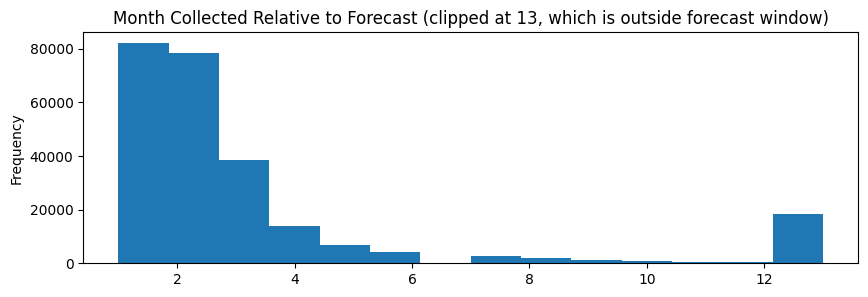

In [73]:
invoices_periods_to_model.month_collected_norm.plot(kind='hist', bins=14, figsize=figsize, 
title="Month Collected Relative to Forecast (clipped at 13, which is outside forecast window)")

<Axes: title={'center': 'Period Collected Relative to Forecast'}, ylabel='Frequency'>

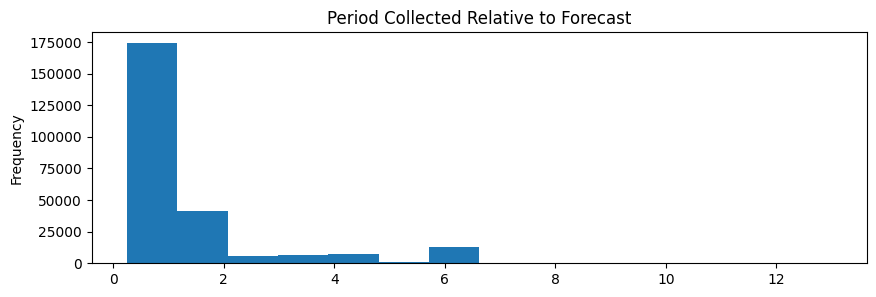

In [74]:
invoices_periods_to_model['period_collected'] = \
(invoices_periods_to_model.month_collected_norm)/(invoices_periods_to_model.months_allowed+1)

invoices_periods_to_model.period_collected.plot(kind='hist', bins=14, figsize=figsize, 
      title="Period Collected Relative to Forecast")

In [75]:
invoices_periods_to_model['collected_per_period'] = invoices_periods_to_model.period_collected\
.map(numpy.reciprocal)
invoices_periods_to_model['collected_per_month'] = invoices_periods_to_model.month_collected_norm\
.map(numpy.reciprocal)

In [76]:
#kurtosis is closest to 0 after normalizing to periods and taking the reciprocal
(invoices_periods_to_model.collected_per_period.kurtosis(), 
 invoices_periods_to_model.collected_per_month.kurtosis(), 
 invoices_periods_to_model.period_collected.kurtosis(), 
 invoices_periods_to_model.month_collected_norm.kurtosis())

(0.102666407880311, -1.3488524784906955, 10.213235408739454, 4.170721844947931)

<Axes: title={'center': 'Average % Collected Per Billing Period'}, ylabel='Frequency'>

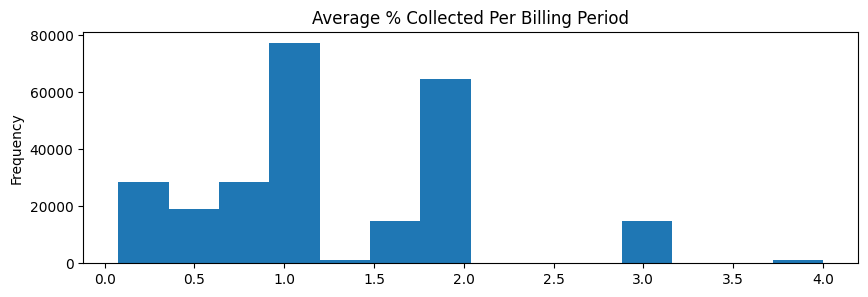

In [77]:
invoices_periods_to_model.collected_per_period\
.plot(kind='hist', bins=14, figsize=figsize, title="Average % Collected Per Billing Period")

In [78]:
from scipy.stats import normaltest
normaltest(invoices_periods_to_model.collected_per_period.values)

NormaltestResult(statistic=17594.277559218903, pvalue=0.0)

In [79]:
invoices_periods_to_model.drop(columns=['cleared_date','month_collected','month_collected_norm',
                                       'period_collected','collected_per_month'], 
                               inplace=True, errors='ignore')
invoices_periods_to_model.describe(include='all', percentiles=[0.001,0.999]).T

,count,unique,top,freq,mean,min,0.1%,50%,99.9%,max,std
invoice_id,250035,90241,34988,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invoice_date,250035,NaN,NaN,NaN,2017-04-02 19:06:22.741616384,2011-04-13 00:00:00,2011-05-18 00:00:00,2017-09-03 00:00:00,2020-05-26 00:00:00,2020-05-31 00:00:00,NaN
months_allowed,"250,035.0000",NaN,NaN,NaN,1.2502,0.0000,0.0000,1.0000,3.0000,3.0000,0.5318
amount_inv,"250,035.0000",NaN,NaN,NaN,"10,034.0164",0.3583,21.9605,"10,051.8132","19,977.5079","19,999.9749","5,756.5608"
currency,250035,17,USD,182090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_id,250035,2,114,242048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,250035,4345,7,5056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forecast_month,250035,NaN,NaN,NaN,2017-04-28 03:17:52.808206848,2011-04-01 00:00:00,2011-06-01 00:00:00,2017-10-01 00:00:00,2020-05-01 00:00:00,2020-05-01 00:00:00,NaN
due_month,250035,113,2019-12,4794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
collected_date,232656,NaN,NaN,NaN,2017-07-07 10:54:30.229007872,2011-05-15 00:00:00,2011-07-24 00:00:00,2017-12-02 00:00:00,2020-10-16 00:00:00,2021-03-21 00:00:00,NaN


## Analyze Input Data

In [80]:
invoices_to_model = invoices_periods_to_model.query("months_billing==0").copy()\
.rename(columns={"forecast_month":"invoice_month"})
invoices_to_model['uncollected'] = invoices_to_model.collected_date.isnull()

### By Dates

<Axes: title={'center': 'Invoices by Forecast Month'}, xlabel='forecast_month'>

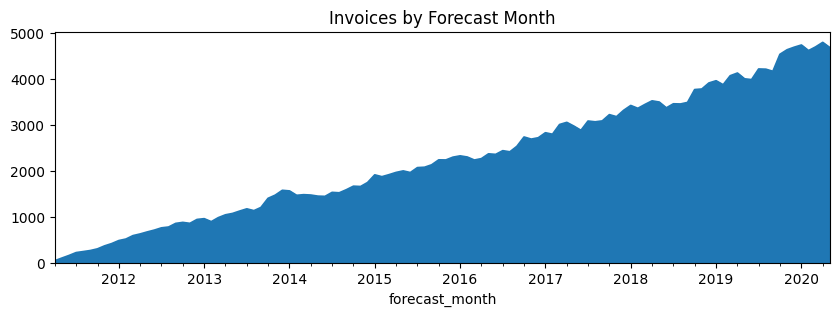

In [81]:
invoices_periods_to_model.groupby("forecast_month").invoice_id.count()\
.plot(kind='area', title="Invoices by Forecast Month", figsize=figsize)

<Axes: title={'center': 'Invoices by Invoice Month'}, xlabel='invoice_month'>

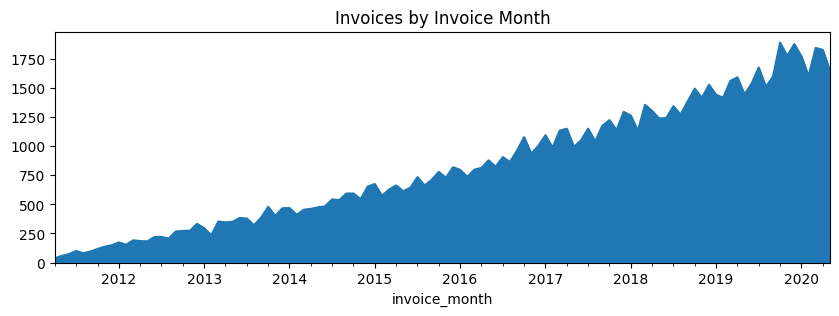

In [82]:
invoices_to_model.groupby("invoice_month").invoice_id.count()\
.plot(kind='area', title="Invoices by Invoice Month", figsize=figsize)

### By Currency

Some currencies have very low collection rates and take multiple billing periods to collect. This may be due to currency fluctuations.

In [83]:
invoices_to_model.groupby("currency")\
.agg({"collected_per_period":["mean","std"],"invoice_id":"count","uncollected":"mean"})\
.sort_values(by=('uncollected','mean'), ascending=False)

collected_per_period        invoice_id uncollected
                         mean    std      count        mean
currency                                                   
TWD                    0.1775 0.1743         11      0.8182
HUF                    0.3681 0.0855          2      0.5000
HKD                    0.7265 0.4127          9      0.3333
INR                    0.6135 0.4856         84      0.2976
BRL                    0.7047 0.4444        465      0.2237
GBP                    0.8933 0.5137       1617      0.1361
SGD                    0.7262 0.4277        211      0.1280
KRW                    0.8553 0.4495         88      0.1250
CHF                    0.7852 0.2921         32      0.0938
CAD                    0.9185 0.5091         23      0.0870
EUR                    0.8270 0.4167      13956      0.0739
CNY                    0.8063 0.4252       1942      0.0685
AUD                    0.7814 0.4179       1115      0.0682
USD                    0.8707 0.3705      67547      0.0562
JPY                    1.0272 0.3910       3127      0.0467
RUB                    1.3439 0.6134         11      0.0000
NZD                    1.0000    NaN          1      0.0000

### Trends Over Time

Invoices are getting collected more quickly relative to their billing period, leading to a greater percentage collected over time - a good sign for Tesorio's business. 

<Axes: title={'center': 'Average % Collected Per Billing Period'}, xlabel='invoice_month'>

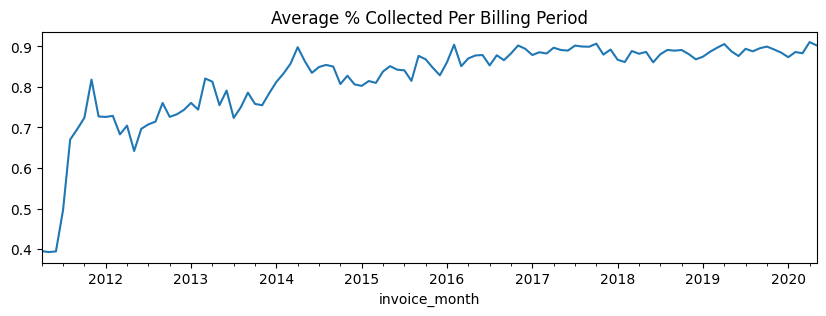

In [84]:
invoices_to_model.groupby("invoice_month").collected_per_period.mean()\
.plot(kind='line', title="Average % Collected Per Billing Period", figsize=figsize)

<Axes: title={'center': '% Invoices Uncollected by Invoice Month'}, xlabel='invoice_month'>

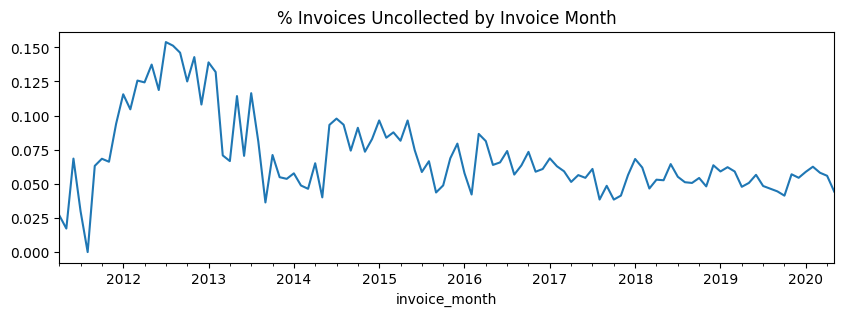

In [85]:
invoices_to_model.groupby("invoice_month").uncollected.mean()\
.plot(kind='line', title="% Invoices Uncollected by Invoice Month", figsize=figsize)

### By Customer 

We have trouble collecting from some customers, regardless of their currency. 

array([[<Axes: title={'center': 'months_allowed'}>,
        <Axes: title={'center': 'amount_inv'}>,
        <Axes: title={'center': 'converted_amount_inv_company'}>],
       [<Axes: title={'center': 'inv_pct_of_company_total'}>,
        <Axes: title={'center': 'months_billing'}>,
        <Axes: title={'center': 'months_late'}>],
       [<Axes: title={'center': 'collected_per_period'}>,
        <Axes: title={'center': 'uncollected'}>, <Axes: >]], dtype=object)

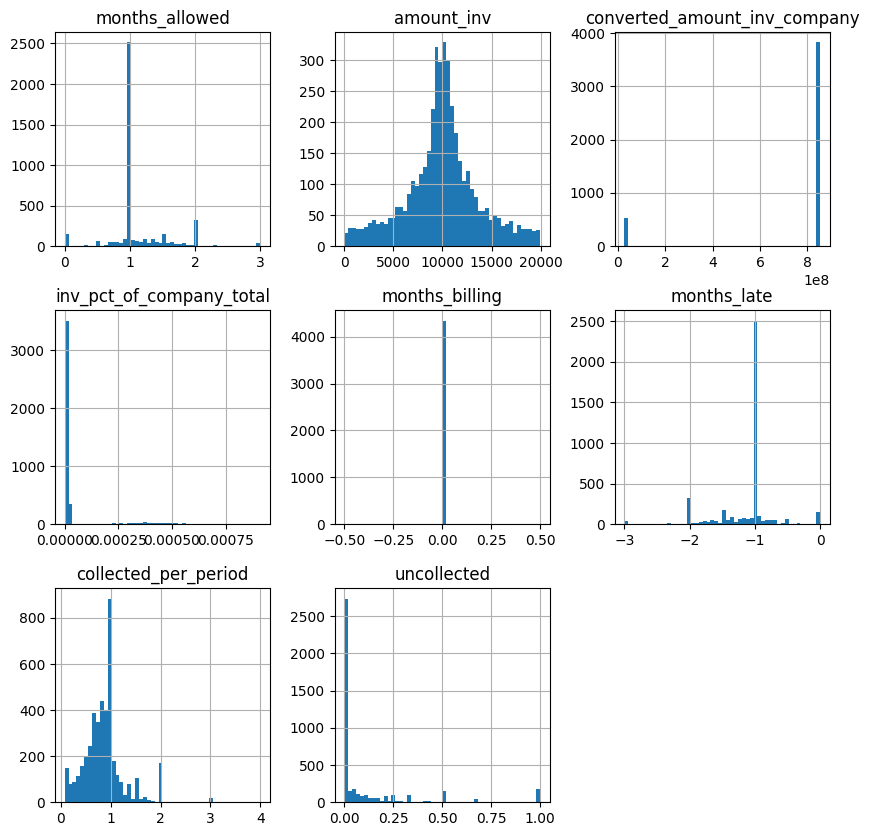

In [510]:
customer_averages = invoices_to_model.set_index("customer_id").select_dtypes(include=['float','int','boolean'])\
.reset_index().groupby("customer_id").mean()
customer_averages.hist(bins=50, figsize=(10,10), layout=(3,3))

<Axes: title={'center': 'Customers with 30+ Invoices: % Uncollected'}, ylabel='Frequency'>

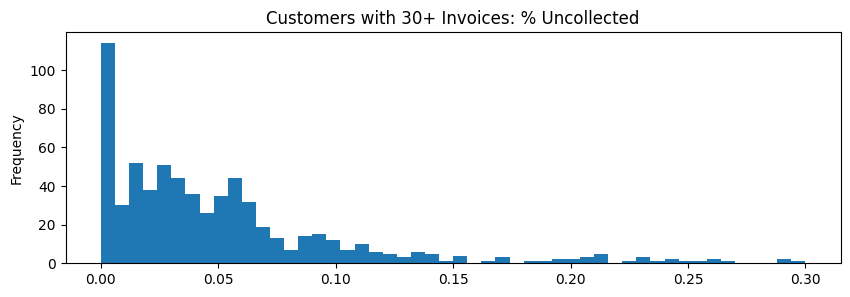

In [87]:
customer_stats = invoices_to_model.groupby("customer_id").uncollected.agg(['count','mean'])\
.add_prefix('uncollected_').sort_values(by="uncollected_mean", ascending=False)
customer_stats.query("uncollected_count>=30").uncollected_mean\
.plot(kind='hist', figsize=figsize, title="Customers with 30+ Invoices: % Uncollected", bins=50)

<Axes: title={'center': 'US and European Customers with 30+ Invoices: % Uncollected'}, ylabel='Frequency'>

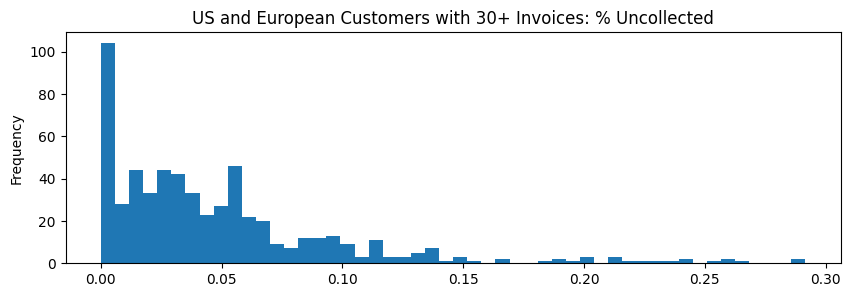

In [88]:
western_customer_stats = invoices_to_model.query("currency in ('USD','EUR','GBP')")\
.groupby("customer_id").uncollected.agg(['count','mean'])\
.add_prefix('uncollected_').sort_values(by="uncollected_mean", ascending=False)
western_customer_stats.query("uncollected_count>=30").uncollected_mean\
.plot(kind='hist', figsize=figsize, title="US and European Customers with 30+ Invoices: % Uncollected", bins=50)

# Business Analysis

## Business Motivation

Cash collections don't follow due dates. On average:

- 6% of total cash due each month is unpaid, equating to a \\$471K average deficit.
- Total cash collected each month is 9% off from the amount due, equating to a $571K average difference in cash flow. 

In [89]:
amount_due = payment_totals.groupby("due_month").converted_amount_inv.sum().to_frame(name="amount_due_usd")
amount_paid = payments.rename(columns={"transaction_month":"due_month"})\
.groupby("due_month").converted_amount.sum().to_frame(name="amount_paid_usd")
business_motivation = amount_due.join(amount_paid, how='inner').reset_index(names='due_month')\
.query(f"due_month>'{first_transaction_date}' and due_month<'{last_transaction_date}'")
business_motivation['pct_unpaid'] = 1 - (business_motivation.amount_paid_usd/business_motivation.amount_due_usd)
business_motivation['unpaid'] = business_motivation.amount_due_usd - business_motivation.amount_paid_usd
business_motivation.set_index('due_month', inplace=True)

<Axes: title={'center': '% Unpaid (USD Due)'}, xlabel='due_month'>

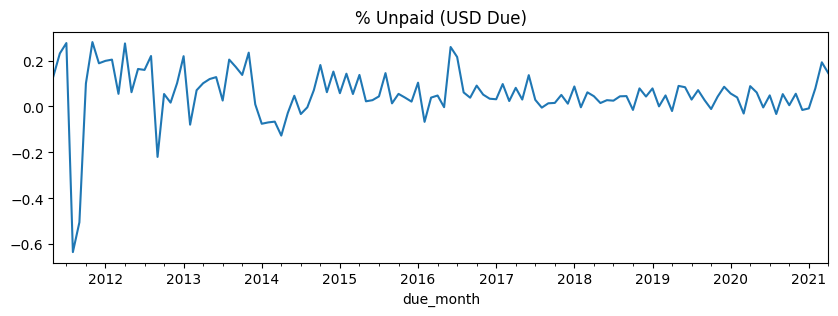

In [90]:
business_motivation.pct_unpaid.plot(figsize=figsize, title="% Unpaid (USD Due)")

In [91]:
business_motivation.pct_unpaid.mean(), business_motivation.pct_unpaid.abs().mean()

(0.055369114130323256, 0.08972281867977448)

<Axes: title={'center': 'USD Unpaid'}, xlabel='due_month'>

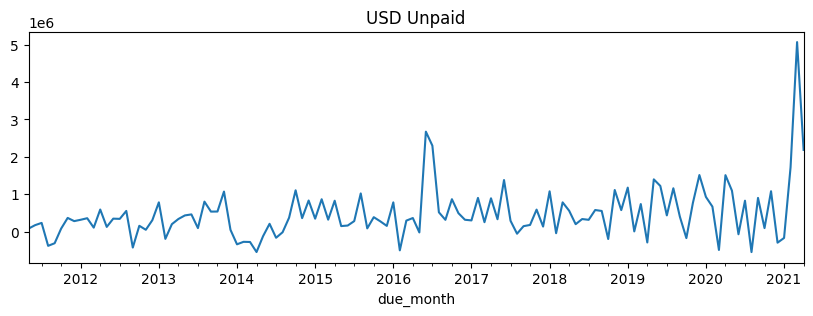

In [92]:
business_motivation.unpaid.plot(figsize=figsize, title="USD Unpaid")

In [93]:
business_motivation.unpaid.mean(), business_motivation.unpaid.abs().mean()

(471494.2851179037, 570983.6203720493)

## Data Science Benchmark

Companies will be more likely to retain if their monthly forecast error is low as a percentage of their total cash flow.

As a benchmark, we use due date in place of the forecast. On average, monthly cash flow is 15% off from cash due.

In [444]:
amount_due = invoices_to_model.groupby("due_month").inv_pct_of_company_total.sum()\
.to_frame(name="pct_of_company_total")

amount_paid = payments.rename(columns={"transaction_month":"due_month"}).merge(
    invoices_to_model[["invoice_id","converted_amount_inv_company"]], on="invoice_id",how="inner"
)
amount_paid['pct_of_company_total'] = amount_paid.converted_amount/amount_paid.converted_amount_inv_company
amount_paid = amount_paid.groupby("due_month").pct_of_company_total.sum()\
.to_frame(name="pct_of_company_total")

benchmark = amount_due.join(amount_paid, how='left', lsuffix='_due',rsuffix='_paid').reset_index()\
.query(f"due_month>'{first_transaction_date}' and due_month<'{last_transaction_date}'")
benchmark['pct_unpaid'] = 1 - (benchmark.pct_of_company_total_paid/benchmark.pct_of_company_total_due)
benchmark['abs_pct_error'] = benchmark.pct_unpaid.abs()
numpy.average(benchmark['abs_pct_error'], weights=benchmark.pct_of_company_total_due)

0.1491113703592089

## ML Task

In [293]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 15 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_lauren_2s7a8d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.05 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [243]:
#time-based split
invoices_periods_to_model['invoice_date_fold']=(invoices_periods_to_model.invoice_date.rank(pct=True)*5).round()
#invoice weight is based on the company-adjusted amount. unit is number of rows
invoices_periods_to_model['inv_company_weight'] = \
invoices_periods_to_model.inv_pct_of_company_total*invoices_periods_to_model.invoice_id.nunique()\
/invoices_periods_to_model.company_id.nunique()
invoices_periods_to_model.inv_company_weight.sum(), invoices_periods_to_model.__len__()

(252184.83784861903, 250035)

In [245]:
id_columns_h2o = [col for col in id_columns if col in invoices_periods_to_model.columns]
invoices_periods_to_model_h2o = h2o.H2OFrame(invoices_periods_to_model, 
           column_types=dict(zip(id_columns_h2o,["string"] * len(id_columns_h2o))))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [294]:
train = invoices_periods_to_model_h2o[invoices_periods_to_model_h2o['invoice_date_fold'] < 5]
valid = invoices_periods_to_model_h2o[invoices_periods_to_model_h2o['invoice_date_fold'] >= 5]

In [489]:
y='collected_per_period'
x = ['months_allowed','amount_inv','inv_pct_of_company_total','currency','months_billing','months_late']

def MAPE_df(pred, act, company_weight_for_invoice, months_allowed):
    df = pandas.DataFrame()
    df['total'] = company_weight_for_invoice
    df['month_pred'] = numpy.reciprocal(pred).multiply(months_allowed+1).clip(upper=13).round()
    df['month_act'] = numpy.reciprocal(act).multiply(months_allowed+1).clip(upper=13).round()
    pred = df.groupby("month_pred", as_index=False).total.sum()
    act = df.groupby("month_act", as_index=False).total.sum()
    err = pred.merge(act,left_on='month_pred',right_on='month_act', how="left", suffixes=('_pred','_act'))
    err['abs_pct_err'] = (1 - err.total_act/err.total_pred).abs()
    return numpy.average(err.abs_pct_err, weights=err.total_pred)

def MAPE_single(pred, act, company_weight_for_invoice, months_allowed):
    month_pred = min(numpy.reciprocal(pred) * (months_allowed+1),13).round()
    month_act = min(numpy.reciprocal(act) * (months_allowed+1),13).round()
    # pred = df.groupby("month_pred", as_index=False).total.sum()
    # act = df.groupby("month_act", as_index=False).total.sum()
    # err = pred.merge(act,left_on='month_pred',right_on='month_act', how="left", suffixes=('_pred','_act'))
    # err['abs_pct_err'] = (1 - err.total_act/err.total_pred).abs()
    return company_weight_for_invoice if month_pred!=month_act else 0

class MAPE_per_period:
    
    import numpy, collections
    def map(self, pred, act, company_weight_for_invoice, months_allowed, model):
        return MAPE_single(pred[0], act[0], company_weight_for_invoice, months_allowed)

    def reduce(self, l, r):
        return [l[0] + r[0], l[1] + r[1]]

    def metric(self, last):
        return last[0] / last[1]
    
custom_mape_func = h2o.upload_custom_metric(MAPE_per_period,func_name="MAPE_per_period")

In [504]:
#gamma distribution represents a period of time until an event. 
#custom loss is only supported for GBM and DRF models in H2O
aml = H2OAutoML(max_runtime_secs=60, include_algos=['GBM'], distribution='gamma', sort_metric='mae')
aml_model = aml.train(x=x , y=y, training_frame=train, validation_frame=valid, 
                      weights_column='inv_company_weight',fold_column='invoice_date_fold') 

AutoML progress: |
12:00:15.830: Fold column invoice_date_fold will be used for cross-validation. nfolds parameter will be ignored.
12:00:15.830: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


In [512]:
MAPE_df(aml_model.predict(valid).as_data_frame().iloc[:,0],valid[y].as_data_frame().iloc[:,0],
     valid['inv_company_weight'].as_data_frame().iloc[:,0],valid['months_allowed'].as_data_frame().iloc[:,0])

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.0

In [506]:
# MAPE_single(aml_model.predict(valid).as_data_frame().iloc[0,0],valid[y].as_data_frame().iloc[0,0],
#      valid['inv_company_weight'].as_data_frame().iloc[0,0],valid['months_allowed'].as_data_frame().iloc[0,0])

In [508]:
aml_model.mae(),aml_model.mae(valid=True)

(0.548478176614578, 0.5318125681556729)

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# gbm_params = {k: v['actual'] for k, v in aml.leader.params.items() \
#               if v['default']!=v['actual'] and type(v['default'])==type(v['actual'])}
gbm_params = {}
# gbm_params['custom_metric_func'] = custom_mape_func
# gbm_params['stopping_metric'] = 'custom'
gbm_params['stopping_metric'] = 'mae'
gbm_params['max_runtime_secs']=10
gbm_params['stopping_rounds'] = 1
gbm_params['stopping_tolerance'] = 0.9
gbm_custom = H2OGradientBoostingEstimator(**gbm_params)
gbm_custom = gbm_custom.train(x=x, y=y, training_frame=train) 
                              # validation_frame=valid, 
                              # weights_column='inv_company_weight',fold_column='invoice_date_fold', 
                              # offset_column="months_allowed") 

In [501]:
gbm_custom.r2(), gbm_custom.r2(valid=True)

(0.09792499709534686, None)